# Проект по автоматизации сбора, обработки и загрузки данных с логгеров


**Выполнил: Жиркова Туяра, июнь 2023**

# Описание проекта


 Для решения научных задач и быстрого, точного анализа данных температуры грунтов с логгеров, работающих по беспроводной линии связи LoRaWAN, необходимо организовать автоматизацию сбора, обработки и загрузки данных.

**Цель — автоматизация сбора, обработки и загрузки данных с логгеров Института мерзлотоведения им. П. И. Мельникова СО РАН**

**Задачи:**

- **Загрузка данных из базы данных типа MySQL** 
- **Просмотр, анализ и предобработка данных**
- **Выгрузка данных в табличном виде в xsl файл**
- **Запуск ETL по расписанию**

**Описание задачи**

Данные приходят с двух логгеров на базу данных типа MySQL.

Нужно написать ETL для логгера Expreremental_3 c 16 датчиками температуры

Первый датчик на поверхности, остальные поочередно на глубине

- '0x28,0xff,0xac,0xb3,0x17,0x20,0x8a,0x40'
- '0x28,0xff,0x38,0x75,0x17,0x20,0x8a,0xd8'
- '0x28,0xff,0x1b,0xa0,0x17,0x20,0x8a,0xee'
- '0x28,0xff,0x1f,0x7b,0x17,0x20,0x8a,0x64'
- '0x28,0xff,0x05,0xa0,0x17,0x20,0x8a,0x30'
- '0x28,0xff,0xd6,0x9f,0x17,0x20,0x8a,0xf2c'
- '0x28,0xff,0xeb,0x98,0x17,0x20,0x8a,0x1c'
- '0x28,0xff,0x66,0xa8,0x17,0x20,0x8a,0x73'
- '0x28,0xff,0xc6,0x9d,0x17,0x20,0x8a,0x89'
- '0x28,0xff,0x30,0x75,0x17,0x20,0x8a,0xe6'
- '0x28,0xff,0x9d,0xb3,0x17,0x20,0x8a,0x09'
- '0x28,0xff,0x11,0xx17,0x20,0x8a,0x04'
- '0x28,0xff,0xa8,0x97,0x17,0x20,0x8a,0x21'


**Описание базы данных**
- База данных logger
- логгер Expreremental_3
- Таблица json
  - Колонка id - уникальный номер 
  - Колонка time - дата и время
  - Колонка string - json строка типа object с данными температуры, названия датчика, имени датчика, заряда батареи на датчике

**Чтобы оценить корректность и целостность данных:**

- Просмотреть уникальные значения температуры на каждом датчике
- Построить график количества данных 

# Подготовка данных

## Загрузка данных

In [1]:
# установка нужной библиотеки 
!pip3 install psycopg2

In [2]:
# импортируем библиотеки
import pandas as pd
from datetime import datetime
import datetime
import requests
import json
from pprint import pprint 
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
#считывание и сохранение данных с json файл. Для портфолио выгрузила кусок данных
with open('json.json', 'r') as f:
    data2 = json.load(f)

In [4]:
len(data2)

3

In [5]:
# вырез нужных данных
data2=data2[2]

In [6]:
len(data2)

4

In [7]:
# вырез нужных данных
data2=data2['data']

In [8]:
len(data2)

20000

In [9]:
# вырез последней части данных, для портфолио
data2=data2[5000:]

In [10]:
len(data2)

15000

In [11]:
# создание таблицы из данных
df = pd.DataFrame(data2)

df.info()

## Просмотр данных

In [12]:
df

,id,time,string,logs_id
0,14632,2023-07-02 19:40:44,"{""dr"": 5, ""adr"": true, ""data"": ""Hyj/MHUXIIrmAA...",0
1,14633,2023-07-02 19:40:52,"{""dr"": 5, ""adr"": true, ""data"": ""Lyg8fsg4GQGfAI...",0
2,14634,2023-07-02 19:40:54,"{""tags"": {}, ""devEUI"": ""qGEKMjdCdAE="", ""margin...",0
3,14635,2023-07-02 19:40:54,"{""dr"": 5, ""adr"": true, ""data"": ""Hyj/qJcXIIohAA...",0
4,14636,2023-07-02 19:40:58,"{""dr"": 5, ""adr"": true, ""data"": ""Lyi8QLU5GQHNAI...",0
...,...,...,...,...
14995,29627,2023-07-14 23:05:01,"{""dr"": 5, ""adr"": true, ""data"": ""Gig8fsg4GQGfAI...",0
14996,29628,2023-07-14 23:05:11,"{""dr"": 5, ""adr"": true, ""data"": ""Gii8QLU5GQHNAA...",0
14997,29629,2023-07-14 23:05:22,"{""dr"": 5, ""adr"": true, ""data"": ""Giiq08Q5GQH6AA...",0
14998,29630,2023-07-14 23:05:32,"{""dr"": 5, ""adr"": true, ""data"": ""GijqebQ5GQGpAA...",0


**В колонке 'string' в виде json строки все данные о температуре грунтов, заряде батареи, координат местонахождения логгера . Необходимо из каждой строчки колонки string вытащить значения температуы, используя названия датчиков как ключ**

## Предобработка данных

In [13]:
# перевод типа столбца 'id' из строчного в числовой
df['id']=pd.to_numeric(df['id'], errors='coerce')

In [14]:
# перевод типа столбца 'time' из строчного в datetime
df['time']=pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   id       15000 non-null  int64         
 1   time     15000 non-null  datetime64[ns]
 2   string   15000 non-null  object        
 3   logs_id  15000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 468.9+ KB


In [16]:
# создание таблицы для логгера "deviceName\": \"Expreremental_3\"
exp3 = pd.DataFrame(columns=['id', 'time'])

In [17]:
# скопировать столбцы 'id' и 'time' из таблицы df в таблицу exp3
for i in range(len(df)):
    exp3.loc[i,'id']=df.loc[i,'id']
    exp3.loc[i,'time']=df.loc[i,'time']

In [18]:
exp3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      15000 non-null  object
 1   time    15000 non-null  object
dtypes: object(2)
memory usage: 867.6+ KB


In [19]:
# перевод типа столбца 'id' из строчного в числовой
exp3['id']=pd.to_numeric(exp3['id'], errors='coerce')

In [20]:
# перевод типа столбца 'time' из строчного в datetime
exp3['time']=pd.to_datetime(exp3['time'], format='%Y-%m-%d %H:%M:%S')

In [21]:
# список установленных датчиков,datchik3 на поверхности, остальное поочередно на глубине
datchik3='0x28,0xff,0xac,0xb3,0x17,0x20,0x8a,0x40'
datchik2='0x28,0xff,0x38,0x75,0x17,0x20,0x8a,0xd8'
datchik14='0x28,0xff,0x1b,0xa0,0x17,0x20,0x8a,0xee'
datchik15='0x28,0xff,0x1f,0x7b,0x17,0x20,0x8a,0x64'
datchik10='0x28,0xff,0x05,0xa0,0x17,0x20,0x8a,0x30'
datchik7='0x28,0xff,0xd6,0x9f,0x17,0x20,0x8a,0xf2'
datchik13='0x28,0xff,0xeb,0x98,0x17,0x20,0x8a,0x1c'
datchik6='0x28,0xff,0x66,0xa8,0x17,0x20,0x8a,0x73'
datchik5='0x28,0xff,0xc6,0x9d,0x17,0x20,0x8a,0x89'
datchik0='0x28,0xff,0x30,0x75,0x17,0x20,0x8a,0xe6'
datchik11='0x28,0xff,0x9d,0xb3,0x17,0x20,0x8a,0x09'
datchik8='0x28,0xff,0x11,0x7b,0x17,0x20,0x8a,0xc6'
datchik4='0x28,0xff,0x3a,0xa4,0x17,0x20,0x8a,0xd5'
datchik12='0x28,0xff,0xa3,0xbb,0x17,0x20,0x8a,0x33'
datchik9='0x28,0xff,0x59,0x75,0x17,0x20,0x8a,0x04'
datchik1='0x28,0xff,0xa8,0x97,0x17,0x20,0x8a,0x21'

In [22]:
# функция для считывния из строки с данными температуры для каждого датчика
def sensor_temperature(datchik):
    keyword='Temperature'
    for i in range(len(df)):
        if datchik in df.loc[i,'string']:
            match = re.search(keyword, df.loc[i,'string'])
            if match:
                sub_string = df.loc[i,'string'][match.end()+3:]
                end_index = sub_string.find("}")
                exp3.loc[i,datchik]=sub_string[:end_index]
    return exp3.loc[i,datchik]

In [23]:
#вызов функции для всех датчиков
sensor_temperature(datchik3)
sensor_temperature(datchik2)
sensor_temperature(datchik14)
sensor_temperature(datchik15)
sensor_temperature(datchik10)
sensor_temperature(datchik7)
sensor_temperature(datchik13)
sensor_temperature(datchik6)
sensor_temperature(datchik5)
sensor_temperature(datchik0)
sensor_temperature(datchik11)
sensor_temperature(datchik8)
sensor_temperature(datchik4)
sensor_temperature(datchik12)
sensor_temperature(datchik9)
sensor_temperature(datchik1)

nan

In [24]:
exp3

,id,time,"0x28,0xff,0xac,0xb3,0x17,0x20,0x8a,0x40","0x28,0xff,0x38,0x75,0x17,0x20,0x8a,0xd8","0x28,0xff,0x1b,0xa0,0x17,0x20,0x8a,0xee","0x28,0xff,0x1f,0x7b,0x17,0x20,0x8a,0x64","0x28,0xff,0x05,0xa0,0x17,0x20,0x8a,0x30","0x28,0xff,0xd6,0x9f,0x17,0x20,0x8a,0xf2","0x28,0xff,0xeb,0x98,0x17,0x20,0x8a,0x1c","0x28,0xff,0x66,0xa8,0x17,0x20,0x8a,0x73","0x28,0xff,0xc6,0x9d,0x17,0x20,0x8a,0x89","0x28,0xff,0x30,0x75,0x17,0x20,0x8a,0xe6","0x28,0xff,0x9d,0xb3,0x17,0x20,0x8a,0x09","0x28,0xff,0x11,0x7b,0x17,0x20,0x8a,0xc6","0x28,0xff,0x3a,0xa4,0x17,0x20,0x8a,0xd5","0x28,0xff,0xa3,0xbb,0x17,0x20,0x8a,0x33","0x28,0xff,0x59,0x75,0x17,0x20,0x8a,0x04","0x28,0xff,0xa8,0x97,0x17,0x20,0x8a,0x21"
0,14632,2023-07-02 19:40:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.6875,NaN,NaN,NaN,NaN,NaN,NaN
1,14633,2023-07-02 19:40:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14634,2023-07-02 19:40:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14635,2023-07-02 19:40:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.3125
4,14636,2023-07-02 19:40:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,29627,2023-07-14 23:05:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14996,29628,2023-07-14 23:05:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14997,29629,2023-07-14 23:05:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14998,29630,2023-07-14 23:05:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
exp3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   id                                       15000 non-null  int64         
 1   time                                     15000 non-null  datetime64[ns]
 2   0x28,0xff,0xac,0xb3,0x17,0x20,0x8a,0x40  216 non-null    object        
 3   0x28,0xff,0x38,0x75,0x17,0x20,0x8a,0xd8  216 non-null    object        
 4   0x28,0xff,0x1b,0xa0,0x17,0x20,0x8a,0xee  210 non-null    object        
 5   0x28,0xff,0x1f,0x7b,0x17,0x20,0x8a,0x64  210 non-null    object        
 6   0x28,0xff,0x05,0xa0,0x17,0x20,0x8a,0x30  213 non-null    object        
 7   0x28,0xff,0xd6,0x9f,0x17,0x20,0x8a,0xf2  215 non-null    object        
 8   0x28,0xff,0xeb,0x98,0x17,0x20,0x8a,0x1c  210 non-null    object        
 9   0x28,0xff,0x66,0xa8,0x17,0x20,0x8a,0x73

In [26]:
# запись в таблицу exp3 имени логгера
device_name='Expreremental_3'
for i in range(len(df)):
    if device_name in df.loc[i,'string']:
        exp3.loc[i,'device_name']='Expreremental_3'

In [27]:
exp3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   id                                       15000 non-null  int64         
 1   time                                     15000 non-null  datetime64[ns]
 2   0x28,0xff,0xac,0xb3,0x17,0x20,0x8a,0x40  216 non-null    object        
 3   0x28,0xff,0x38,0x75,0x17,0x20,0x8a,0xd8  216 non-null    object        
 4   0x28,0xff,0x1b,0xa0,0x17,0x20,0x8a,0xee  210 non-null    object        
 5   0x28,0xff,0x1f,0x7b,0x17,0x20,0x8a,0x64  210 non-null    object        
 6   0x28,0xff,0x05,0xa0,0x17,0x20,0x8a,0x30  213 non-null    object        
 7   0x28,0xff,0xd6,0x9f,0x17,0x20,0x8a,0xf2  215 non-null    object        
 8   0x28,0xff,0xeb,0x98,0x17,0x20,0x8a,0x1c  210 non-null    object        
 9   0x28,0xff,0x66,0xa8,0x17,0x20,0x8a,0x73

In [28]:
#exp3 = exp3.dropna(subset=['device_name']) 

In [29]:
exp3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   id                                       15000 non-null  int64         
 1   time                                     15000 non-null  datetime64[ns]
 2   0x28,0xff,0xac,0xb3,0x17,0x20,0x8a,0x40  216 non-null    object        
 3   0x28,0xff,0x38,0x75,0x17,0x20,0x8a,0xd8  216 non-null    object        
 4   0x28,0xff,0x1b,0xa0,0x17,0x20,0x8a,0xee  210 non-null    object        
 5   0x28,0xff,0x1f,0x7b,0x17,0x20,0x8a,0x64  210 non-null    object        
 6   0x28,0xff,0x05,0xa0,0x17,0x20,0x8a,0x30  213 non-null    object        
 7   0x28,0xff,0xd6,0x9f,0x17,0x20,0x8a,0xf2  215 non-null    object        
 8   0x28,0xff,0xeb,0x98,0x17,0x20,0x8a,0x1c  210 non-null    object        
 9   0x28,0xff,0x66,0xa8,0x17,0x20,0x8a,0x73

In [30]:
exp3.columns = ['id', 'time','0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','Название логгера']

In [31]:
exp3.head(5)

,id,time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Название логгера
0,14632,2023-07-02 19:40:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.6875,NaN,NaN,NaN,NaN,NaN,NaN,Expreremental_3
1,14633,2023-07-02 19:40:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14634,2023-07-02 19:40:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expreremental_3
3,14635,2023-07-02 19:40:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.3125,Expreremental_3
4,14636,2023-07-02 19:40:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# перевод значений температуры в числовой тип из строчного
for column in ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15']:
    exp3[column]=pd.to_numeric(exp3[column], errors='coerce' )


In [51]:
exp3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3418 entries, 0 to 3417
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                3418 non-null   int64         
 1   time              3418 non-null   datetime64[ns]
 2   0                 216 non-null    float64       
 3   1                 216 non-null    float64       
 4   2                 210 non-null    float64       
 5   3                 210 non-null    float64       
 6   4                 213 non-null    float64       
 7   5                 215 non-null    float64       
 8   6                 210 non-null    float64       
 9   7                 215 non-null    float64       
 10  8                 216 non-null    float64       
 11  9                 216 non-null    float64       
 12  10                211 non-null    float64       
 13  11                214 non-null    float64       
 14  12                216 no

In [34]:
#удаление строк без значений темпетаруты 
exp3=exp3.dropna (thresh= 4)

In [35]:
# новое индексирование строк бз пропусков
exp3 = exp3.drop_duplicates().reset_index(drop=True)

## Анализ полученных данных

In [36]:
# начало передачи данных
exp3['time'].min()

Timestamp('2023-07-02 19:40:44')

In [37]:
# конец передачи данных
exp3['time'].max()

Timestamp('2023-07-14 22:37:38')

In [38]:
# продолжительность передачи данных
exp3['time'].max()-exp3['time'].min()

Timedelta('12 days 02:56:54')

In [39]:
# просмотр уникальных данных температуры для датчика 0, на поверхности земли
exp3['0'].unique()

array([    nan, 28.4375, 27.375 , 26.25  , 25.1875, 24.3125, 23.9375,
       23.5   , 23.0625, 22.9375, 23.3125, 24.125 , 26.    , 26.125 ,
       27.6875, 29.625 , 31.0625, 31.875 , 32.25  , 32.375 , 32.5625,
       31.3125, 30.0625, 29.0625, 28.0625, 26.875 , 25.6875, 24.5625,
       23.5625, 22.75  , 22.    , 21.4375, 22.5625, 22.875 , 25.5   ,
       25.8125, 27.5625, 29.3125, 29.9375, 30.9375, 30.4375, 29.5625,
       28.5625, 27.1875, 24.25  , 22.3125, 21.625 , 20.9375, 20.5   ,
       20.125 , 20.8125, 21.5625, 22.1875, 26.5625, 28.    , 27.8125,
       28.6875, 24.8125, 23.6875, 22.4375, 21.25  , 20.1875, 19.5   ,
       19.    , 18.5   , 19.25  , 19.375 , 21.5   , 23.    , 25.375 ,
       26.3125, 26.8125, 26.5   , 26.375 , 27.75  , 28.125 , 19.75  ,
       18.75  , 17.75  , 17.0625, 16.5   , 16.9375, 17.625 , 19.3125,
       22.0625, 24.0625, 19.4375, 22.125 , 27.875 , 28.25  , 24.    ,
       22.5   , 21.1875, 19.875 , 18.8125, 17.8125, 17.    , 21.125 ,
       23.375 , 32.6

Температуры соответсвуют июльской погоде

In [40]:
# просмотр уникальных данных температуры для датчика 1
exp3['1'].unique()

array([nan, '13', '13.0625', '13.125', '13.1875', '13.25', '13.3125',
       '13.375', '13.4375', '13.5', '12.9375', '12.875', '12.8125',
       '12.75', '12.6875', '12.625', '12.5625', '12.5', '12.4375',
       '12.375', '12.3125', '10.875', '10.8125', '10.75', '10.6875',
       '10.625', '10.5625', '10.5', '10.4375', '10.375', '10.3125',
       '10.25'], dtype=object)

In [41]:
# просмотр уникальных данных температуры для датчика 2
exp3['2'].unique()

array([nan, '3.875', '3.9375', '4', '4.0625', '4.125', '4.1875', '4.25',
       '4.3125', '4.375', '4.4375', '4.5', '4.5625', '4.625', '4.75',
       '4.6875'], dtype=object)

In [42]:
# просмотр уникальных данных температуры для датчика 3
exp3['3'].unique()

array([nan, '-0.5', '-0.4375', '-0.375', '-0.3125', '0.125', '0.1875',
       '0.25', '0.3125', '0.375', '0.4375', '0.5', '0.5625', '0.625',
       '0.6875', '0.75', '0.8125', '0.875', '0.9375'], dtype=object)

In [43]:
# просмотр уникальных данных температуры для датчика 4
exp3['4'].unique()

array([nan, '-1.5625', '-1.5', '-1.4375', '-1.375', '-1.3125', '-1.25',
       '-1.1875'], dtype=object)

In [44]:
# просмотр уникальных данных температуры для датчика 5
exp3['5'].unique()

array([nan, '-2', '-1.9375', '-1.875', '-1.8125'], dtype=object)

Температуры грунтов на глубине постепенно снижаются, что соответствует действительности

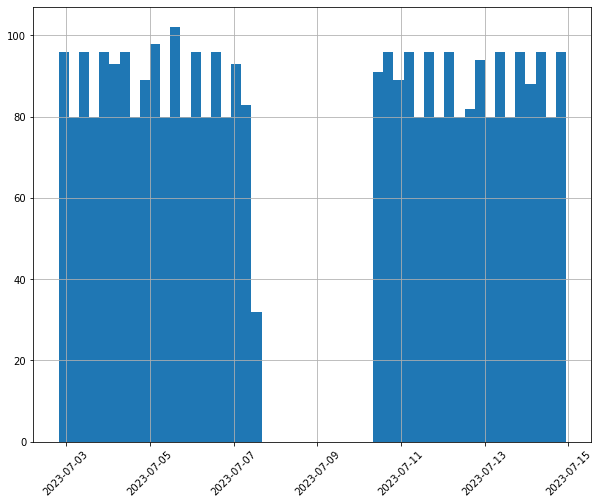

In [66]:
fig = plt.figure(figsize=(10, 8))
exp3['time'].hist(bins=50)
# поворачиваем подписи оси x на 45 градусов
plt.xticks(rotation=45);

C 8 по 10 июля есть перерыв передачи данных

In [67]:
# выгрузка в xslx файл
exp3.to_excel('./exp3_logger.xlsx')

# Вывод

Цель по автоматизации ETL данных логгера успешно выполнена. Данные загружаются в Excel файл exp3_logger.xlsx в табличном виде. 

Данные температуры корректны. Есть перерыв в передаче данных с 8 по 10 июля